# Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from collections import Counter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Loading the dataset

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Checking variables, NAs of the dataset

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In train dataset there are:
* 177 null values in Age column
* 687 null values in Cabin column
* 2 null values in Embarked column

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In test dataset there are:
* 86 null values in Age column
* 1 null value in Fare column
* 327 null values in Cabin column

In [9]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Ayoub, Miss. Banoura",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Samaan, Mr. Elias",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [11]:
#Checking weather data is balanced or imbalanced
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

There are 549 0s and 342 1s, hence data is balanced.

# Exploratory data analysis

Let's see who survived more, male or female.

        Survived
Sex             
female  0.742038
male    0.188908


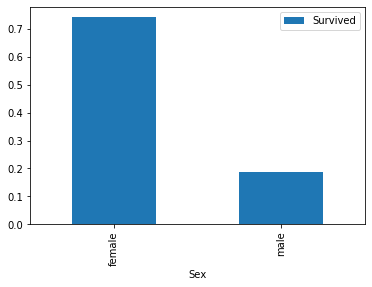

In [12]:
print(train.pivot_table(values = 'Survived', index = 'Sex'))
train.pivot_table(values = 'Survived', index = 'Sex').plot(kind = 'bar')

From above data and graph we can see that female survived more than male.

Let's check which age group among male and female survived more.

Text(0.5, 1.0, 'Age distribution of male and female')

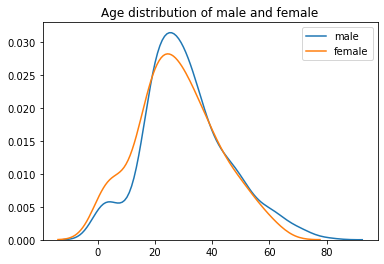

In [13]:
sns.kdeplot(train[train['Sex']=='male']['Age'], label = 'male')
sns.kdeplot(train[train['Sex']=='female']['Age'],label = 'female')
plt.legend()
plt.title('Age distribution of male and female')

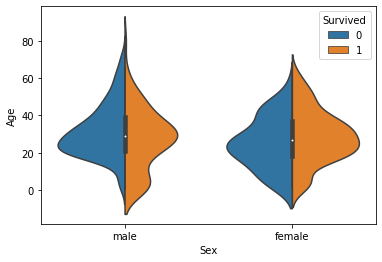

In [14]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train, split=True)

Female, children and old people were given preference by the rescue team and hence they mostly survived.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc3e71c1d0>,
      dtype=object)

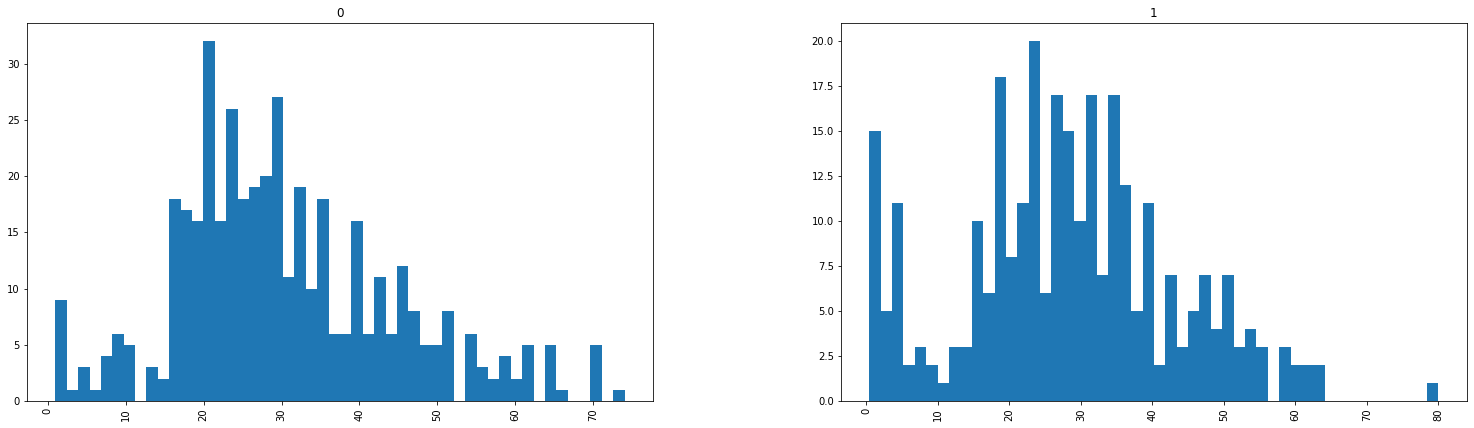

In [15]:
#Let's see the relation between Age and Survived column using graph
train.hist(column="Age",by="Survived",bins=50,figsize=(25,7))

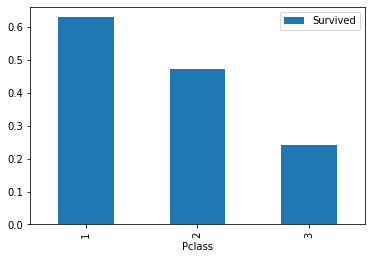

In [16]:
#Now let's see the relation between Pclass and survived column using graph
train.pivot_table(values=['Survived'],index=['Pclass']).plot(kind='bar')

3    491
1    216
2    184
Name: Pclass, dtype: int64


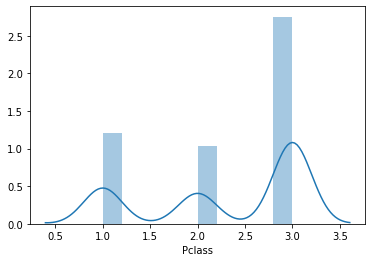

In [17]:
print(train['Pclass'].value_counts())
sns.distplot(train['Pclass'])

There are highest number of passenger in class 3 and passengers of class 1 survived most and passengers of class 3 survived least. Hence it can be concluded that passengers of class 1 were given preference over other two classes.

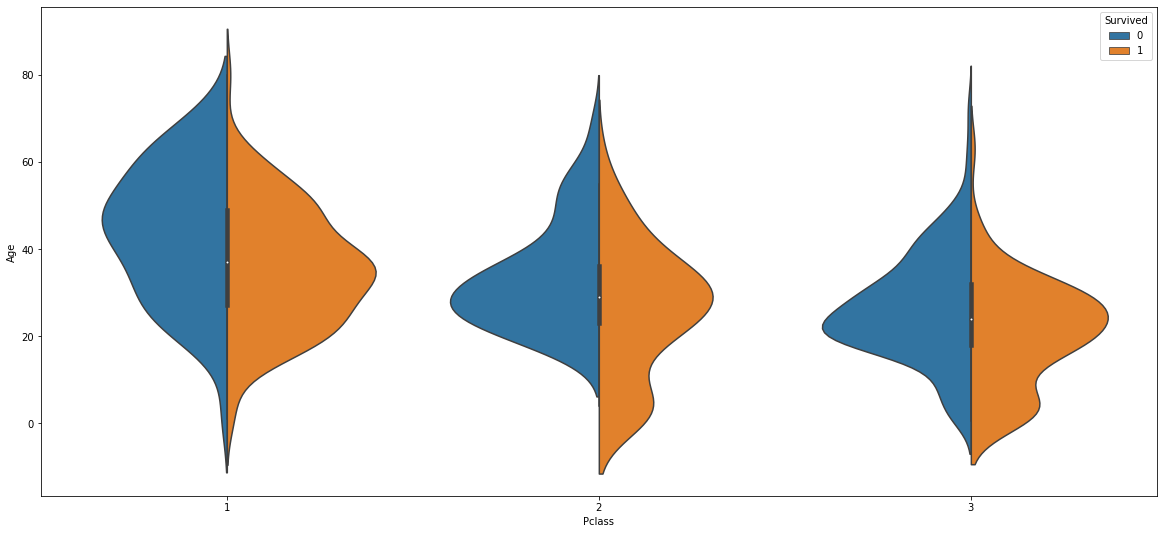

In [18]:
#Now combine all Pclass, Age and Survived in one graph and see the result
plt.figure(figsize=(20,9))
sns.violinplot(x='Pclass', y='Age', hue='Survived',data=train, split=True)

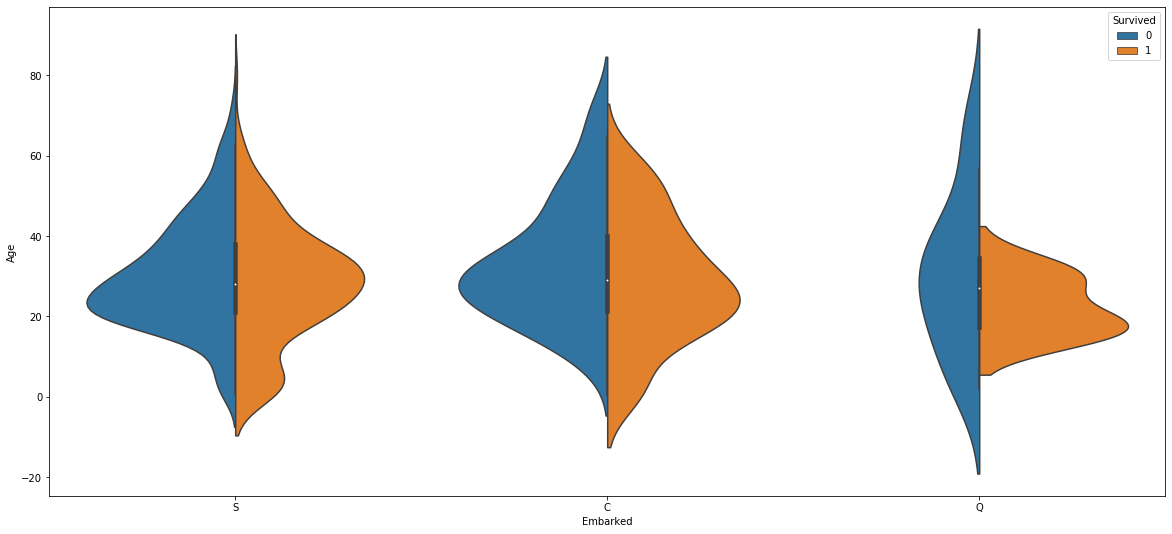

In [19]:
#Visualizing of which stoppage passenger died most and of which age group
plt.figure(figsize=(20,9))
sns.violinplot(x='Embarked', y='Age', hue='Survived',data=train, split=True)
#C = Cherbourg, Q = Queenstown, S = Southampton

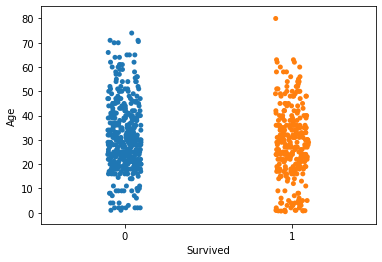

In [20]:
#Distribution of Age vs Survived
sns.stripplot(train['Survived'],train['Age'], jitter=True)

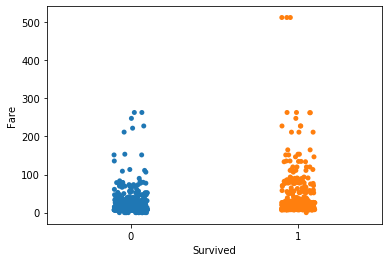

In [21]:
#Distribution of Fare vs Survived
sns.stripplot(train['Survived'],train['Fare'], jitter=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc3e2ce3d0>,
      dtype=object)

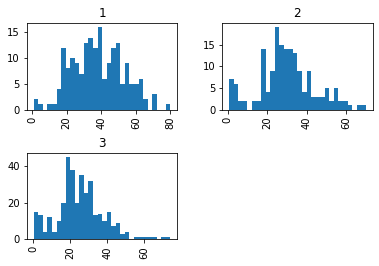

In [22]:
#Distribution of age in different classes
train.hist(column="Age",by="Pclass",bins=30)

# Data cleaning

### Detecting outliers

In [23]:
def detect_outlier(df,n,cols):
    outlier_indices = []
    for i in cols:
        Q1 = np.percentile(df[i], 25)
        Q3 = np.percentile(df[i], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5*IQR
        outlier_index_list = df[(df[i] < Q1-outlier_step) | (df[i] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_index_list)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v>n)  
    return multiple_outliers

In [24]:
#We are dropping only those indices whose count is at least 2. 
outliers_to_drop = detect_outlier(train,2,['Age', 'SibSp', 'Parch', 'Fare'])
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [25]:
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

We have dropped 10 rows.

### Loading the Data,Combining and removing unnecessary columns

In [26]:
# extracting and then removing the targets from the training data 
targets = train.Survived
train.drop(['Survived'], 1, inplace=True)
    

# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

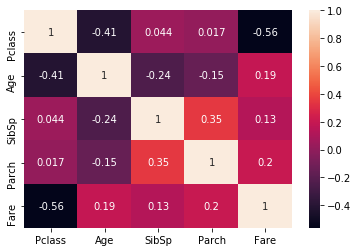

In [27]:
#Correlation between different features
sns.heatmap(combined.corr(), annot = True)

In [28]:
print(targets.shape)
combined.shape

(881,)


(1299, 10)

In [29]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1299 non-null   int64  
 1   Name      1299 non-null   object 
 2   Sex       1299 non-null   object 
 3   Age       1043 non-null   float64
 4   SibSp     1299 non-null   int64  
 5   Parch     1299 non-null   int64  
 6   Ticket    1299 non-null   object 
 7   Fare      1298 non-null   float64
 8   Cabin     292 non-null    object 
 9   Embarked  1297 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 101.6+ KB


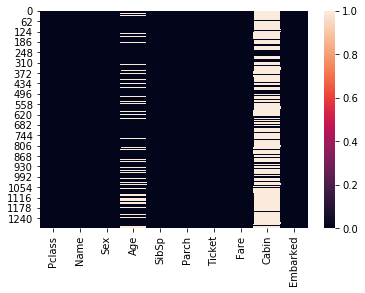

In [30]:
#Visualizing null values in the dataset
sns.heatmap(combined.isnull())

We have null values in Age, Fare, Cabin and Embarked columns

In [31]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning Name column
In Name column we have all unique string in each row, so we will extract titles of each row.

In [32]:
#Let's see all the titles
titles = set()
for name in train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
print(titles)

{'Don', 'Mrs', 'Mlle', 'Capt', 'Jonkheer', 'Master', 'Col', 'Dr', 'Lady', 'Major', 'the Countess', 'Rev', 'Miss', 'Ms', 'Sir', 'Mme', 'Mr'}


In [33]:
#We will extract titles in 'Title' column
combined['Title'] = combined['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [34]:
pd.crosstab(combined['Title'],combined['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [35]:
#Replacing some titles to the most common titles
combined['Title'] = combined['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined['Title'] = combined['Title'].replace('Mlle', 'Miss')
combined['Title'] = combined['Title'].replace('Ms', 'Miss')
combined['Title'] = combined['Title'].replace('Mme', 'Mrs')
#Mapping titles to numerical data
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
combined['Title'] = combined['Title'].map(title_mapping)
combined['Title'] = combined['Title'].fillna(0)
##dropping Name feature
combined = combined.drop(['Name'], axis=1)

In [36]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,1,female,35.0,1,0,113803,53.1000,C123,S,3
4,3,male,35.0,0,0,373450,8.0500,NaN,S,1


### Processing Sex column

In [37]:
combined["Sex"][combined["Sex"] == "male"] = 0
combined["Sex"][combined["Sex"] == "female"] = 1
combined["Sex"] = combined["Sex"].astype(int)

In [38]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,1,1,35.0,1,0,113803,53.1000,C123,S,3
4,3,0,35.0,0,0,373450,8.0500,NaN,S,1


### Processing Age column

In [39]:
#Age column in highly crrelated with Pclass column
combined.groupby('Pclass')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,281.0,39.343132,14.514617,0.92,28.5,39.0,50.0,80.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.0,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.0,74.0


In [40]:
#Filling null values with median of ages in different classes
combined['Age'] = combined.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

In [41]:
combined["Age"] = combined["Age"].astype(int)

In [42]:
#cutting age in different groups
combined['Age_cat'] = pd.qcut(combined['Age'],q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)

In [43]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_cat
0,3,0,22,1,0,A/5 21171,7.2500,NaN,S,1,1
1,1,1,38,1,0,PC 17599,71.2833,C85,C,3,4
2,3,1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,2,3
3,1,1,35,1,0,113803,53.1000,C123,S,3,4
4,3,0,35,0,0,373450,8.0500,NaN,S,1,4


### Processing Ticket column

In [44]:
#Keeping only alphabets and removing numbers from ticket name, 
#if there is no any alphabets then replace the string with "x"
tickets = []
for i in list(combined.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")

In [45]:
combined['Ticket'] = tickets

In [46]:
combined = pd.get_dummies(combined, columns= ["Ticket"], prefix = "T")

In [47]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age_cat,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x
0,3,0,22,1,0,7.2500,NaN,S,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,38,1,0,71.2833,C85,C,3,4,...,0,0,0,0,0,0,0,0,0,0
2,3,1,26,0,0,7.9250,NaN,S,2,3,...,0,0,0,0,1,0,0,0,0,0
3,1,1,35,1,0,53.1000,C123,S,3,4,...,0,0,0,0,0,0,0,0,0,1
4,3,0,35,0,0,8.0500,NaN,S,1,4,...,0,0,0,0,0,0,0,0,0,1


### Processing Fare column
Here we simply fill the null values of fare with the mean in the train set and ignore the values which have zero fare for first iteration,After testing our model for the first time ,we will come back and check again if treating those values would make a difference

In [48]:
combined['Fare'] = combined.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median())) 

In [49]:
combined['Zero_Fare'] = combined['Fare'].map(lambda x: 1 if x == 0 else (0))

In [50]:
def fare_category(fr): 
    if fr <= 7.91:
        return 1
    elif fr <= 14.454 and fr > 7.91:
        return 2
    elif fr <= 31 and fr > 14.454:
        return 3
    return 4

In [51]:
combined['Fare_cat'] = combined['Fare'].apply(fare_category) 

In [52]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 49 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     1299 non-null   int64  
 1   Sex        1299 non-null   int64  
 2   Age        1299 non-null   int64  
 3   SibSp      1299 non-null   int64  
 4   Parch      1299 non-null   int64  
 5   Fare       1299 non-null   float64
 6   Cabin      292 non-null    object 
 7   Embarked   1297 non-null   object 
 8   Title      1299 non-null   int64  
 9   Age_cat    1299 non-null   int64  
 10  T_A        1299 non-null   uint8  
 11  T_A4       1299 non-null   uint8  
 12  T_A5       1299 non-null   uint8  
 13  T_AQ3      1299 non-null   uint8  
 14  T_AQ4      1299 non-null   uint8  
 15  T_AS       1299 non-null   uint8  
 16  T_C        1299 non-null   uint8  
 17  T_CA       1299 non-null   uint8  
 18  T_CASOTON  1299 non-null   uint8  
 19  T_FC       1299 non-null   uint8  
 20  T_FCC   

### Processing Embarked column

In [53]:
combined["Embarked"] = combined["Embarked"].fillna("C")
combined["Embarked"][combined["Embarked"] == "S"] = 1
combined["Embarked"][combined["Embarked"] == "C"] = 2
combined["Embarked"][combined["Embarked"] == "Q"] = 3
combined["Embarked"] = combined["Embarked"].astype(int)

In [54]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age_cat,...,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x,Zero_Fare,Fare_cat
0,3,0,22,1,0,7.2500,NaN,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38,1,0,71.2833,C85,2,3,4,...,0,0,0,0,0,0,0,0,0,4
2,3,1,26,0,0,7.9250,NaN,1,2,3,...,0,0,1,0,0,0,0,0,0,2
3,1,1,35,1,0,53.1000,C123,1,3,4,...,0,0,0,0,0,0,0,1,0,4
4,3,0,35,0,0,8.0500,NaN,1,1,4,...,0,0,0,0,0,0,0,1,0,2


### Processing Family column

In [55]:
#Creating a new feature which contains number of members of family
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1

In [56]:
#Grouping FamilySize in different categories
combined['FamilySize_cat'] = combined['FamilySize'].map(lambda x: 1 if x == 1 
                                                            else (2 if 5 > x >= 2 
                                                                  else (3 if 8 > x >= 5 
                                                                       else 4 )
                                                                 ))   

In [57]:
#Creating a new feature Alone
combined['Alone'] = [1 if i == 1 else 0 for i in combined['FamilySize']]

In [58]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age_cat,...,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x,Zero_Fare,Fare_cat,FamilySize,FamilySize_cat,Alone
0,3,0,22,1,0,7.2500,NaN,1,1,1,...,0,0,0,0,0,0,1,2,2,0
1,1,1,38,1,0,71.2833,C85,2,3,4,...,0,0,0,0,0,0,4,2,2,0
2,3,1,26,0,0,7.9250,NaN,1,2,3,...,0,0,0,0,0,0,2,1,1,1
3,1,1,35,1,0,53.1000,C123,1,3,4,...,0,0,0,0,1,0,4,2,2,0
4,3,0,35,0,0,8.0500,NaN,1,1,4,...,0,0,0,0,1,0,2,1,1,1


### Processing Cabin column

In [59]:
#Filling null values in Cabin feature with 'U'
combined['Cabin'] = combined['Cabin'].fillna('U')

In [60]:
#Keeping only first letter of Cabin name
import re
combined['Cabin'] = combined['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

In [61]:
combined['Cabin'].value_counts()

U    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [62]:
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}

In [63]:
combined['Cabin'] = combined['Cabin'].map(cabin_category)

In [64]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age_cat,...,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x,Zero_Fare,Fare_cat,FamilySize,FamilySize_cat,Alone
0,3,0,22,1,0,7.2500,1,1,1,1,...,0,0,0,0,0,0,1,2,2,0
1,1,1,38,1,0,71.2833,7,2,3,4,...,0,0,0,0,0,0,4,2,2,0
2,3,1,26,0,0,7.9250,1,1,2,3,...,0,0,0,0,0,0,2,1,1,1
3,1,1,35,1,0,53.1000,7,1,3,4,...,0,0,0,0,1,0,4,2,2,0
4,3,0,35,0,0,8.0500,1,1,1,4,...,0,0,0,0,1,0,2,1,1,1


In [65]:
#Creating dummy variable from categorical variable
dummy_col=['Title', 'Sex',  'Age_cat', 'SibSp', 'Parch', 'Fare_cat', 'Cabin', 'Embarked', 'Pclass', 'FamilySize_cat']

In [66]:
dummy = pd.get_dummies(combined[dummy_col], columns=dummy_col, drop_first=False)

In [67]:
combined = pd.concat([dummy, combined], axis = 1)

# Feature Engineering

### Creating more features

In [68]:
combined['FareCat_Sex'] = combined['Fare_cat']*combined['Sex']
combined['Pcl_Sex'] = combined['Pclass']*combined['Sex']
combined['Pcl_Title'] = combined['Pclass']*combined['Title']
combined['Age_cat_Sex'] = combined['Age_cat']*combined['Sex']
combined['Age_cat_Pclass'] = combined['Age_cat']*combined['Pclass']
combined['Title_Sex'] = combined['Title']*combined['Sex']
combined['Age_Fare'] = combined['Age_cat']*combined['Fare_cat']

combined['SmallF'] = combined['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
combined['MedF']   = combined['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
combined['LargeF'] = combined['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
combined['Senior'] = combined['Age'].map(lambda s:1 if s>70 else 0)

In [69]:
combined.head()

,Title_1,Title_2,Title_3,Title_4,Title_5,Sex_0,Sex_1,Age_cat_0,Age_cat_1,Age_cat_2,...,Pcl_Sex,Pcl_Title,Age_cat_Sex,Age_cat_Pclass,Title_Sex,Age_Fare,SmallF,MedF,LargeF,Senior
0,1,0,0,0,0,1,0,0,1,0,...,0,3,0,3,0,1,1,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,1,3,4,4,3,16,1,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,3,6,3,9,2,6,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,1,3,4,4,3,16,1,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,3,0,12,0,8,0,0,0,0


In [70]:
combined[['Age_Fare','Title_1']].median()

Age_Fare    4.0
Title_1     1.0
dtype: float64

# Modelling

In [71]:
#Seperating training, test and target datasets from combined dataset
X_train = combined[:train.shape[0]]
X_test = combined[train.shape[0]:]
y = targets
X_train['Y'] = y
df = X_train
X = df.drop('Y', axis=1)
y = df.Y

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [73]:
#Splitting training dataset into training and validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

In [74]:
#Creating dmatrix to train xgboost
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test)

In [75]:
params = {
        'objective':'binary:logistic',
        'eta': 0.3,
        'max_depth':9,
        'learning_rate':0.03,
        'eval_metric':'auc',
        'min_child_weight':1,
        'subsample':1,
        'colsample_bytree':0.4,
        'seed':29,
        'reg_lambda':2.8,
        'reg_alpha':0,
        'gamma':0,
        'scale_pos_weight':1,
        'n_estimators': 600,
        'nthread':-1
}

In [76]:
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000 

In [77]:
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=600, 
                           maximize=True, verbose_eval=10)

[16:31:11] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.89267	valid-auc:0.87943
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 600 rounds.
[10]	train-auc:0.90073	valid-auc:0.89167
[20]	train-auc:0.90500	valid-auc:0.89709
[30]	train-auc:0.91603	valid-auc:0.90780
[40]	train-auc:0.92301	valid-auc:0.91052
[50]	train-auc:0.93076	valid-auc:0.91329
[60]	train-auc:0.93683	valid-auc:0.91237
[70]	train-auc:0.94175	valid-auc:0.91012
[80]	train-auc:0.94486	valid-auc:0.91131
[90]	train-auc:0.94976	valid-auc:0.91184
[100]	train-auc:0.95322	valid-auc:0.91078
[110]	train-auc:0.95721	valid-auc:0.91118
[120]	train-auc:0.96076

In [78]:
#By using these leaks we can get 0.85 to 0.86 score. If we do not use these leaks 
#we can achieve score of 0.77 to 0.78.
leaks = {
897:1,
899:1, 
930:1,
932:1,
949:1,
987:1,
995:1,
998:1,
999:1,
1016:1,
1047:1,
1083:1,
1097:1,
1099:1,
1103:1,
1115:1,
1118:1,
1135:1,
1143:1,
1152:1, 
1153:1,
1171:1,
1182:1,
1192:1,
1203:1,
1233:1,
1250:1,
1264:1,
1286:1,
935:0,
957:0,
972:0,
988:0,
1004:0,
1006:0,
1011:0,
1105:0,
1130:0,
1138:0,
1173:0,
1284:0,
}

In [79]:
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = model.predict(d_test)
sub['Survived'] = sub['Survived'].apply(lambda x: 1 if x>0.8 else 0)
sub['Survived'] = sub.apply(lambda r: leaks[int(r['PassengerId'])] if int(r['PassengerId']) in leaks else r['Survived'], axis=1)
sub.to_csv('sub_titan.csv', index=False)